__собираем статистики по объявлениям о продаже домов__

_Evgeny S. Borisov <parser@mechanoid.su>_

In [1]:
!date

Пн 16 сен 2024 14:01:25 MSK


# загружаем данные

In [35]:
import numpy as np
import pandas as pd
import geopandas as gpd

pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
df = pd.read_pickle('data/2024/df_house.pkl')
df['dt'] = df['ts'].dt.date
display( len(df) )
cols = ['title','address','latitude','longitude','priceM','dt']
display( df.sample(3)[cols] )

57214

title  \
28833       дом 170 м² на участке 3,7 сот.   
9160   дом, 200 м², 4.18 сот., садоводство   
6545     дом, 32 м², 4.5 сот., садоводство   

                                                                 address  \
28833                                           севастополь,рейдовая ул.   
9160                севастополь,р-н гагаринский,мкр.фиолент,чайка-89 снт   
6545   севастополь,р-н гагаринский,таврия садоводческое товарищество,321   

        latitude  longitude  priceM          dt  
28833  44.636061  33.517859   25.00  2024-08-12  
9160   44.537752  33.496353   11.00  2024-06-10  
6545   44.544999  33.481864    4.50  2024-07-22

In [4]:
def address_filter(df):
    #           46.319437, 33.911048
    #
    # 45.402617, 32.455625 |  45.545301, 36.684702
    #
    #          44.320887, 33.917013

    df['latitude'] = pd.to_numeric( df['latitude'], errors='coerce' )
    df['longitude'] = pd.to_numeric( df['longitude'], errors='coerce' )

    df = df.query('(32.4<longitude<36.7) & (44.3<latitude<46.4)') 

#     df.loc[ df['address']=='Севастополь,Чёрное море', ['latitude','longitude'] ] = None
#     df.loc[ df['address'].str.lower().str.match('чёрное море'), ['latitude','longitude'] ] = None 

#     df.loc[ df['address']=='квартал Старый Город', 'place'] = 'turkie'
#     df.loc[ df['address'].str.lower().str.match('анталья'), 'place' ] = 'turkie' 

#     df.loc[ df['address'].str.lower().str.match(r'.*бахчисарай.*'), 'place' ] = 'bahchisaray'
#     df.loc[ df['address'].str.lower().str.match(r'.*севастополь,.*'), 'place' ] = 'sevastopol'

#     df.loc[ df['address'].str.lower().str.match(r'.*мысовское.*'), 'place' ] = 'kerch'
    df.loc[ df['address'].str.lower().str.match(r'.*алушта.*'), 'place' ] = 'alushta'
    df.loc[ df['address'].str.lower().str.match(r'.*гурзуф.*'), 'place' ] = 'gurzuf'

#     df.loc[ df['address'].str.lower().str.match(r'.*с.лучистое.*'), 'place' ] = 'alushta'
#     df.loc[ df['address'].str.lower().str.match(r'.*снт солнечная долина.*'), 'place' ] = 'sudak'
#     df.loc[ df['address'].str.lower().str.match(r'.*пгт.новоозёрное.*'), 'place' ] = 'evpatoria'

#     df.loc[ df['address'].str.lower().str.match(r'.*с.мирное.*'), 'place' ] = 'simferopol'
#     df.loc[ df['address'].str.lower().str.match(r'.*тсн аэрофлот.*'), 'place' ] = 'simferopol'

#     df.loc[ df['address'].str.lower().str.match(r'.*семисот.*'), 'place' ] = 'kerch'

#     df.loc[ df['address'].str.lower().str.match(r'.*заветное.*') , 'place' ] = 'kerch'
    df.loc[ df['address'].str.lower().str.match(r'.*ленинский район.*') , 'place' ] = 'kerch'
    df.loc[ df['address'].str.lower().str.match(r'.*симферопольский район.*'), 'place' ] = 'simferopol'
    df.loc[ df['address'].str.lower().str.match(r'.*белогорский район.*'),'place'] = 'belogorsk'
    df.loc[ df['address'].str.lower().str.match(r'.*кировский район.*'),'place'] = 'kirovsky'
    
    df.loc[ df['address'].str.lower().str.match(r'.*ялта.*') , 'place' ] = 'yalta'
    df.loc[ df['address'].str.lower().str.match(r'.*феодосия.*') , 'place' ] = 'feodosia'
    df.loc[ df['address'].str.lower().str.match(r'.*окуневка.*') , 'place' ] = 'tarkhankut'
    df.loc[ df['address'].str.lower().str.match(r'.*евпатория.*') , 'place' ] = 'evpatoria'

    df = df.dropna(subset=['latitude','longitude'])
    
    return df

In [5]:
display( len(df) )
df = address_filter(df)
display( len(df) )

57214

57210

---

In [6]:
# df_ = pd.read_pickle('data/2023/data_house.pkl').rename(columns={'adr':'address'})
# df_['dt'] = df_['ts'].dt.date
# display( len(df_) )
# display( df_.sample(3)[cols] )

In [7]:
# df_ = (
#         df_
#         .dropna(subset=['dt','url'])
#         .drop_duplicates(['dt','url'])
#         .drop(columns=['adr_orig','obj_name','avito_page'])
#     )
# display( len(df_) )
# cols = ['title','address','latitude','longitude','priceM','dt','url']
# display( df_.sample(3)[cols] )

In [8]:
# # history_date = df_['dt'].max()
# history_date = pd.to_datetime('2023-01-10').date()
# display(history_date)

In [9]:
# df = pd.concat([df,df_]).reset_index(drop=True)
# display( len(df) )
# del df_

---

In [10]:
df['month'] = df['ts'].dt.to_period('M')
df['week'] = df['ts'].dt.to_period('W')

---

In [11]:
# display( len(df) )
# df = df.dropna(subset=['latitude','longitude'])
# display( len(df) )

In [12]:
display(len(df))
# выкидываем "ущербные" варианты 
df = df.query('~(is_part) & (house_area>40.) & (priceM<15.)')
display(len(df))
df = df.query('priceM>1.') # выкидываем предожения с аномально низкой ценой
display(len(df))

57210

39953

39892

In [13]:
gdf = gpd.GeoDataFrame( df, geometry = gpd.points_from_xy( df['longitude'], df['latitude']), crs='epsg:4326', )
# [['title','address','latitude','longitude','priceM']] 
display( gdf.sample(3)[cols])

title  \
982    дом, 54 м², 5.4 сот., садоводство   
20045           дом, 156 м², 4 сот., ижс   
48904       дом 170 м² на участке 6 сот.   

                                                                    address  \
982      севастополь,р-н нахимовский,аленушка садоводческое товарищество,20   
20045  республика крым,судак,ветеран садовое товарищество,улица центральная   
48904                                              бахчисарай,ул.тынчлыкъ,2   

       latitude  longitude  priceM          dt  
982       44.58      33.57    7.00  2024-06-11  
20045     44.86      35.00   12.00  2024-06-13  
48904     44.76      33.89   14.50  2024-07-08

---

---

In [14]:
dt_max = df['dt'].max()
dt_min = df['dt'].min()
print( dt_min, ' : ',dt_max )
# display( dt_min,history_date,dt_max )

2024-06-07  :  2024-09-16


In [15]:
display( len(gdf) )
gdf = (
    gdf
    .query("place in ('sevastopol','sudak','bahchisaray')")
    # .drop_duplicates(['dt','url'])
    .drop_duplicates(['url','week'])
    .reset_index(drop=True)
)
display( len(gdf) )

39892

28961

In [16]:
# df[ df['address'].str.match('ялта') ]

In [17]:
# gdf = gdf.query('place in ("bahchisaray","sudak","sevastopol")')

In [18]:
# gdf_history = gdf.query(f'dt <= @history_date')
# gdf = gdf.query(f'dt > @history_date')

In [19]:
# display( len(gdf_history) )
# display( len(gdf) )

---

In [20]:
# cols = ['title','address','latitude','longitude','priceM','dt','place','url']
# gdf[ (gdf['place']=='sevastopol') & (gdf['address'].str.match(r'.*Судак.*')) ][cols]

In [21]:
# gdf['place'].unique()

# общая статистика

In [22]:
gdf[['title','address','priceM','geometry']].sample(512).explore()

In [23]:
gdf.query('place=="sevastopol"')[['title','address','priceM','geometry']].sample(512).explore()

In [24]:
# gdf[ gdf['address'].str.match(r'.*ялта.*') ]
# gdf[ gdf['address'].str.match(r'.*окуневка.*') ]
# gdf[ gdf['address'].str.match(r'.*заветное.*') ]

In [25]:
gdf.query('place=="bahchisaray"')[['title','address','priceM','geometry']].explore()

In [26]:
gdf.query('place=="sudak"')[['title','address','priceM','geometry']].explore()

In [27]:
percentiles=[.01,.05,.1,.25,.5,.75,.9,.95]
stat = (
        #gdf.groupby(['place','house_size_category','month'],observed=True)
        gdf.groupby(['place','house_size_category','week'],observed=True)
    
        ['priceM'].describe(percentiles=percentiles)
    )

# display( stat )

In [28]:
stat.reset_index()['house_size_category'].unique()

['30-50', '50-70', '70-110', '110-180', '180-300', '300+']
Categories (6, object): ['30-50' < '50-70' < '70-110' < '110-180' < '180-300' < '300+']

In [29]:
import matplotlib.pyplot as plt

cols = ['1%','10%','25%','50%','75%']
# sizes = stat.reset_index()['house_size_category'].unique()
sizes = ['50-70', '70-110','110-180', '180-300' ]
# sizes = ['50-70', '70-150','150-300' ]
display(sizes)

['50-70', '70-110', '110-180', '180-300']

In [30]:
# display(len(gdf))
# gdf_ = gdf[ gdf['house_size_category'].isin(sizes) ].reset_index()
# display(len(gdf_))
# gdf_[['title','house_size_category']]

In [31]:
# dt_now = pd.to_datetime('2024-06-17').date()
# dt_now = gdf['dt'].max()

In [32]:
# (
# gdf
# .query('house_size_category in @sizes')
# .drop_duplicates(['url'])
# .groupby(['house_size_category','place'],observed=True)['url'].count()
# .reset_index()
# .pivot(index='place', columns='house_size_category', values='url')
# .plot.barh(title='количество предложений') #,log=True)
# .grid(axis='x')    
# )

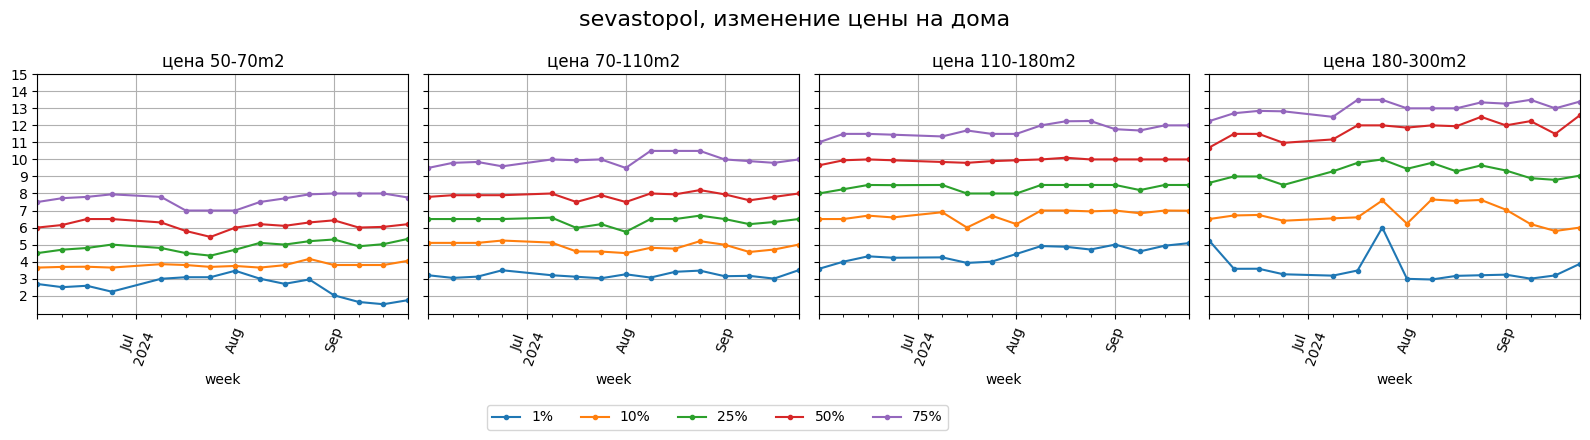

In [36]:
place = 'sevastopol'

fig, ax = plt.subplots(1,len(sizes),figsize=(16,4), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(place,s),cols].plot(title=f'цена {s}m2', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   
    ax[i].set_yticks( np.arange(2, 16, step=1) )

fig.suptitle(f'{place}, изменение цены на дома', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

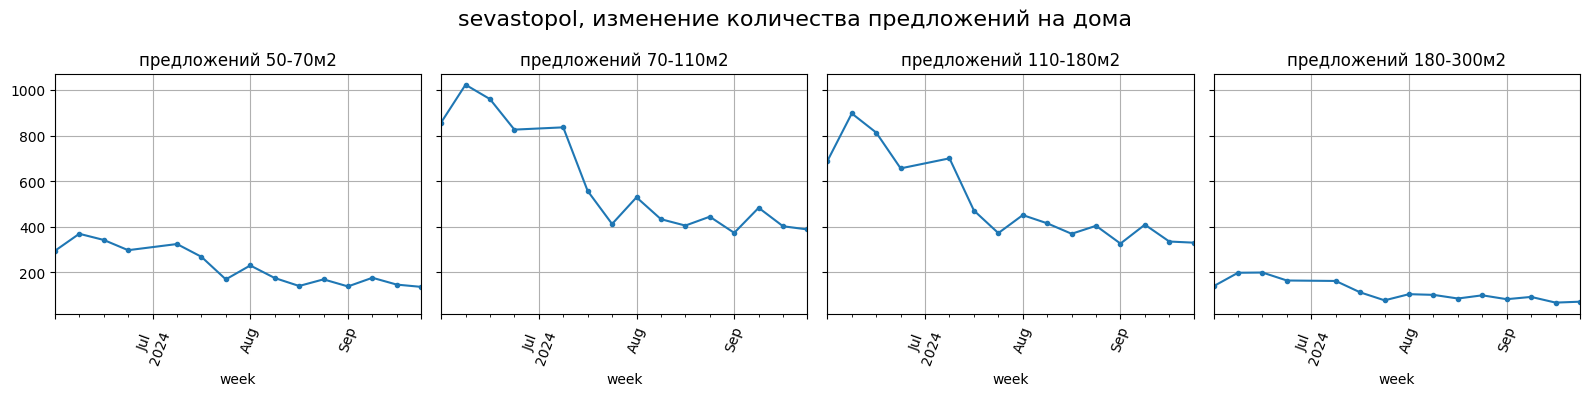

In [37]:
fig, ax = plt.subplots(1,len(sizes),figsize=(16,4), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(place,s),'count'].plot(title=f'предложений {s}м2', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'{place}, изменение количества предложений на дома', fontsize=16)
fig.tight_layout()

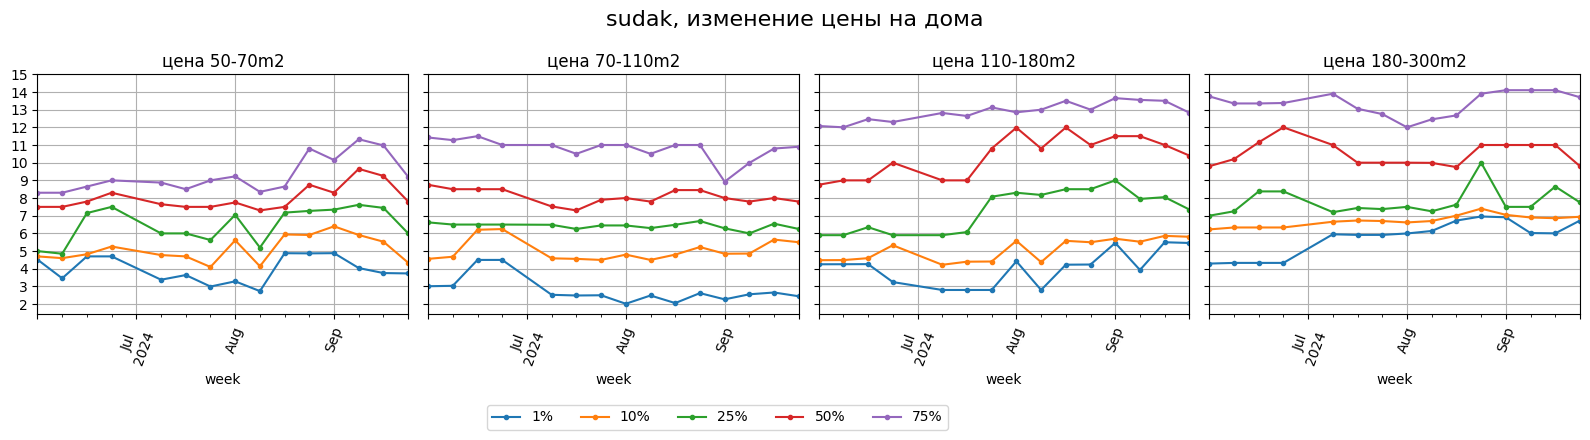

In [38]:
place = 'sudak'

fig, ax = plt.subplots(1,len(sizes),figsize=(16,4), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(place,s),cols].plot(title=f'цена {s}m2', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )  
    ax[i].set_yticks( np.arange(2, 16, step=1) )

fig.suptitle(f'{place}, изменение цены на дома', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

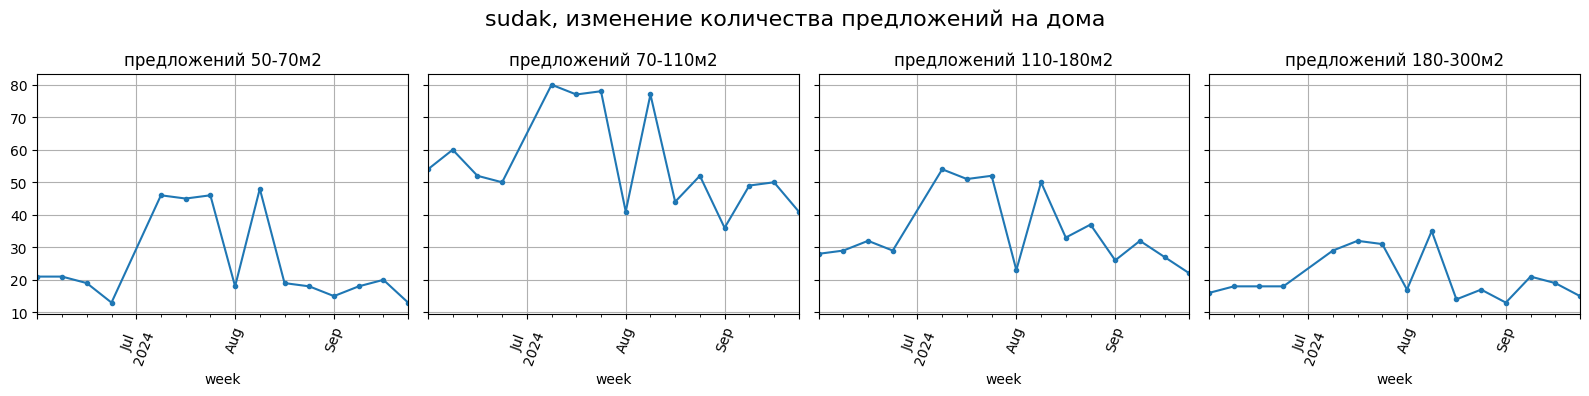

In [39]:
fig, ax = plt.subplots(1,len(sizes),figsize=(16,4), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(place,s),'count'].plot(title=f'предложений {s}м2', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'{place}, изменение количества предложений на дома', fontsize=16)
fig.tight_layout()

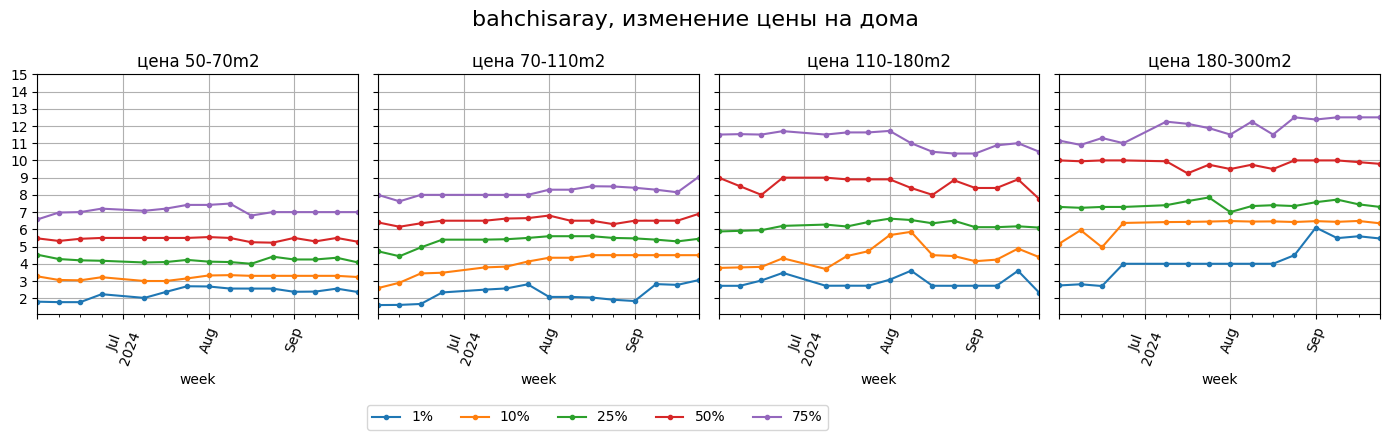

In [43]:
place = 'bahchisaray'

fig, ax = plt.subplots(1,len(sizes),figsize=(14,4), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(place,s),cols].plot(title=f'цена {s}m2', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   
    ax[i].set_yticks( np.arange(2, 16, step=1) )

fig.suptitle(f'{place}, изменение цены на дома', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

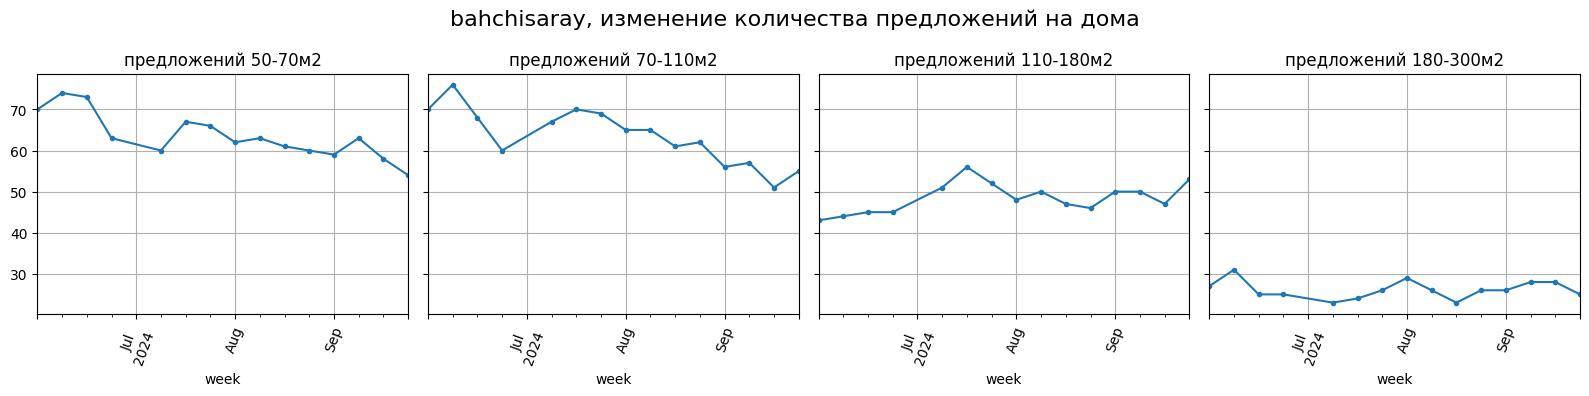

In [44]:
fig, ax = plt.subplots(1,len(sizes),figsize=(16,4), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(place,s),'count'].plot(title=f'предложений {s}м2', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'{place}, изменение количества предложений на дома', fontsize=16)
fig.tight_layout()

# актуальная цена

In [45]:
# dt_now = pd.to_datetime('2024-06-17').date()
dt_now = gdf['dt'].max()
display(len(gdf))
gdf_last = gdf[ gdf['dt'] == dt_now ]
display(len(gdf_last))

28961

1319

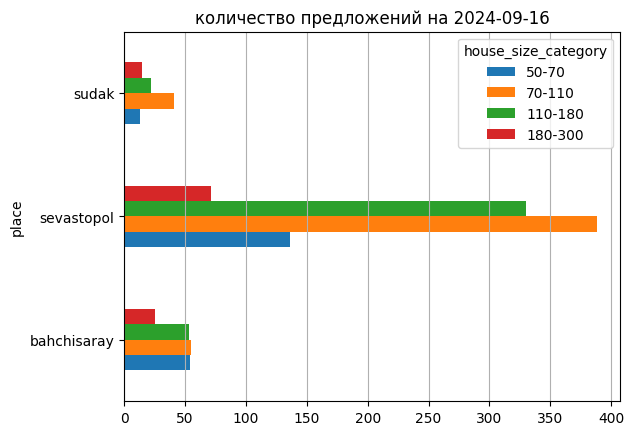

In [46]:
(
gdf_last
.query('house_size_category in @sizes')
.drop_duplicates(['url'])
.groupby(['house_size_category','place'],observed=True)['url'].count()
.reset_index()
.pivot(index='place', columns='house_size_category', values='url')
# .plot.barh(title='количество предложений') #,log=True)
.plot.barh(title='количество предложений на '+ str( dt_now ))
.grid(axis='x')    
)

In [47]:
(
    gdf_last
    .groupby(['place','house_size_category'],observed=False)
    ['priceM'].describe(percentiles=percentiles)
)

count  mean  std   min    1%    5%   10%  \
place       house_size_category                                             
bahchisaray 30-50                33.00  4.13 2.00  2.00  2.00  2.00  2.13   
            50-70                54.00  5.69 2.11  2.20  2.36  2.86  3.23   
            70-110               55.00  7.45 2.77  3.00  3.05  4.05  4.50   
            110-180              53.00  8.29 3.15  1.20  2.31  3.62  4.38   
            180-300              25.00  9.87 2.88  5.30  5.47  6.05  6.35   
            300+                  4.00 11.50 1.29 10.00 10.03 10.15 10.30   
sevastopol  30-50                55.00  5.45 1.86  2.80  2.91  3.20  3.56   
            50-70               136.00  6.67 2.36  1.30  1.74  3.60  4.05   
            70-110              388.00  8.28 2.49  3.00  3.50  4.36  5.00   
            110-180             330.00 10.22 2.55  3.45  5.09  5.93  6.99   
            180-300              71.00 11.14 3.10  3.00  3.88  5.50  6.00   
            300+                 10.00 10.82 2.87  5.50  5.74  6.71  7.93   
sudak       30-50                 9.00  7.32 2.93  4.10  4.13  4.26  4.42   
            50-70                13.00  7.85 2.64  3.70  3.74  3.88  4.34   
            70-110               41.00  8.20 2.77  1.50  2.44  4.50  5.50   
            110-180              22.00  9.98 3.10  5.45  5.46  5.51  5.81   
            180-300              15.00 10.31 3.00  6.70  6.73  6.84  6.94   
            300+                  5.00 10.10 1.34  9.00  9.00  9.00  9.00   

                                  25%   50%   75%   90%   95%   max  
place       house_size_category                                      
bahchisaray 30-50                2.40  3.75  5.00  6.46  8.40  9.70  
            50-70                4.08  5.28  7.00  9.13  9.84 10.00  
            70-110               5.45  6.90  9.05 10.77 13.02 14.50  
            110-180              6.10  7.75 10.50 12.64 13.82 14.55  
            180-300              7.30  9.80 12.50 13.60 14.37 14.60  
            300+                10.75 11.50 12.25 12.70 12.85 13.00  
sevastopol  30-50                4.11  5.10  6.55  7.55  9.50 11.00  
            50-70                5.34  6.20  7.76  9.50 11.38 13.90  
            70-110               6.50  8.00 10.00 11.70 12.50 14.50  
            110-180              8.50 10.00 12.00 13.91 14.50 14.96  
            180-300              9.05 12.60 13.40 14.00 14.38 14.95  
            300+                 8.72 11.79 12.00 14.50 14.50 14.50  
sudak       30-50                6.30  6.80  7.50 10.16 12.08 14.00  
            50-70                6.00  7.80  9.20 11.26 11.90 12.50  
            70-110               6.25  7.80 10.90 12.50 12.50 13.00  
            110-180              7.35 10.40 12.82 13.70 13.94 14.00  
            180-300              7.75  9.80 13.70 14.16 14.29 14.50  
            300+                 9.00  9.50 11.00 11.60 11.80 12.00

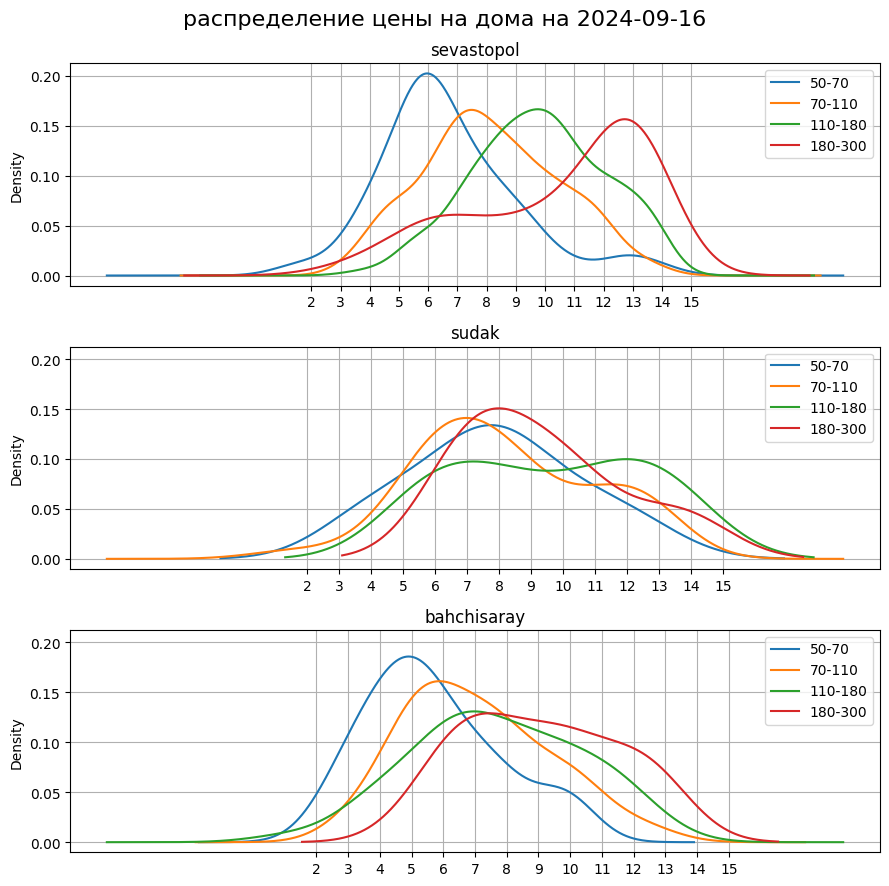

In [49]:
q_95 = gdf_last.groupby(['place'])['priceM'].quantile(.95)

places = ['sevastopol','sudak','bahchisaray']

fig, ax = plt.subplots(len(places),1,figsize=(9,9), sharey=True )
for i,p in enumerate(places): 
    (
        gdf_last
        .query(f' (place=="{p}") & (priceM<{q_95[p]}) & (house_size_category in {sizes})')
        .groupby(['house_size_category'],observed=True)
        ['priceM']
        .plot.kde(legend=True,ax=ax[i],title=f'{p}', grid=True)   
    )
    ax[i].set_xticks( np.arange(2, 16, step=1) )

fig.suptitle(f'распределение цены на дома на '+ str( dt_now ), fontsize=16)
fig.tight_layout()

In [50]:
# (
# gdf_last
# .query(f' (place=="{p}") & (priceM<{q_95[p]}) & (house_size_category in {sizes})')
# .groupby(['house_size_category'],observed=True)
# ['priceM'].plot.kde()
# )

# цены на карте

In [51]:
import h3
from shapely.geometry import Polygon
from shapely.geometry import MultiPoint

In [52]:
def cover_grid_hexagonal(gmtr,cell_size=6,crs='EPSG:4326'):
    polygonise = lambda hex_id: Polygon( h3.h3_to_geo_boundary( hex_id, geo_json=True)  )
    hexs = list(h3.polyfill( gmtr.__geo_interface__, cell_size, geo_json_conformant = True ))
    return gpd.GeoDataFrame({ 'hex_id': hexs,  'geometry': list(map(polygonise, hexs)), },crs=crs,)

In [53]:
# cols = ['title','address','latitude','longitude','priceM','dt','url']
# gdf_last.query('place=="sevastopol"')[cols]

In [54]:
# gdf_last[gdf_last['place']=='sevastopol'][cols]

## Севастополь

In [55]:
frame_sevastopol = gpd.GeoDataFrame([{ # все предложения
            'place':'sevastopol', 
            'geometry':MultiPoint( gdf_last.query('place=="sevastopol"')['geometry'].tolist() ).convex_hull, 
        }],crs='EPSG:4326')

frame_sevastopol.explore()

In [56]:
grid = cover_grid_hexagonal( frame_sevastopol.geometry.values[0],cell_size=7 )
grid_values = ( 
    grid
    .sjoin( gdf_last.query('place=="sevastopol"'), how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)
grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)

## Судак

In [57]:
frame_sudak = gpd.GeoDataFrame([{ # все предложения
            'place':'sudak', 
            'geometry':MultiPoint( gdf_last.query('place=="sudak"')['geometry'].tolist() ).convex_hull, 
        }],crs='EPSG:4326')

# frame_sudak.explore()

In [58]:
grid = cover_grid_hexagonal( frame_sudak.geometry.values[0],cell_size=8 )
grid_values = ( 
    grid
    .sjoin( gdf_last.query('place=="sudak"'), how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)
grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)

# районы Севастополя

In [59]:
# загружаем области поиска
frames_path = 'data/frames/'
frames_index = pd.read_csv(f'{frames_path}/_index.tsv',sep='\t')

swap_coo = lambda coo : [ (c[1],c[0]) for c in coo ]
df2poly = lambda df : Polygon(swap_coo(df.values))

frames = gpd.GeoDataFrame([ 
        { 'area_name':nm, 'geometry': df2poly( pd.read_csv(f'{frames_path}/{f}',header=None) ) } 
        for nm,f in frames_index.values
    ],crs='epsg:4326',)

In [60]:
display(frames)

area_name  \
0     Севастополь, район Острякова   
1  Севастополь, парк 60-летия СССР   
2  Севастополь, Хрусталёва/Хрюкина   
3  Севастополь, Геловани/Коломийца   
4     Севастополь, Музыки/Бирюзова   
5   Севастополь, кр.горка (старый)   
6    Севастополь, кр.горка (новый)   
7      Севастополь, Малахов курган   
8       Севастополь, Благополучный   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        geometry  
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                          POLYGON ((33.51618 44.58832, 33.52597 44.58817, 33.53399 44.57315, 33.54248 44.55177, 33.52583 44.55023, 33.51174 44.57861, 33.51253 44.58565, 33.51253 44.58565, 33.51618 44.58832))  
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   POLYGON ((33.51805 44.58404, 33.51458 44.58408, 33.51263 44.58031, 33.51435 44.57460, 33.52004 44.57520, 33.51805 44.58404))  
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             POLYGON ((33.52003 44.57511, 33.52527 44.56364, 33.52116 44.56136, 33.51942 44.56406, 33.51951 44.56384, 33.51874 44.56882, 33.51426 44.57444, 33.52003 44.57511))  
3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             POLYGON ((33.52139 44.57296, 33.53034 44.57518, 33.53318 44.57413, 33.53369 44.57139, 33.53244 44.56878, 33.53123 44.56774, 33.52440 44.56640, 33.52139 44.57296))  
4                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [61]:
frames.explore('area_name', legend=True)

In [62]:
area_name=[
#'Севастополь, парк 60-летия СССР',
#'Севастополь, Хрусталёва/Хрюкина',
#'Севастополь, район Острякова',
#'Севастополь, Малахов курган',
'Севастополь, кр.горка (старый)',
'Севастополь, кр.горка (новый)',
'Севастополь, Благополучный',
]

In [63]:
# выбираем область
frame_ = frames[frames['area_name'].isin(area_name)]

# фильтруем данные по области
gdf_last_local = gdf_last.sjoin( frame_, how='inner', predicate='within') 
gdf_last_local[['title','priceM','address','geometry']].explore( legend=False)

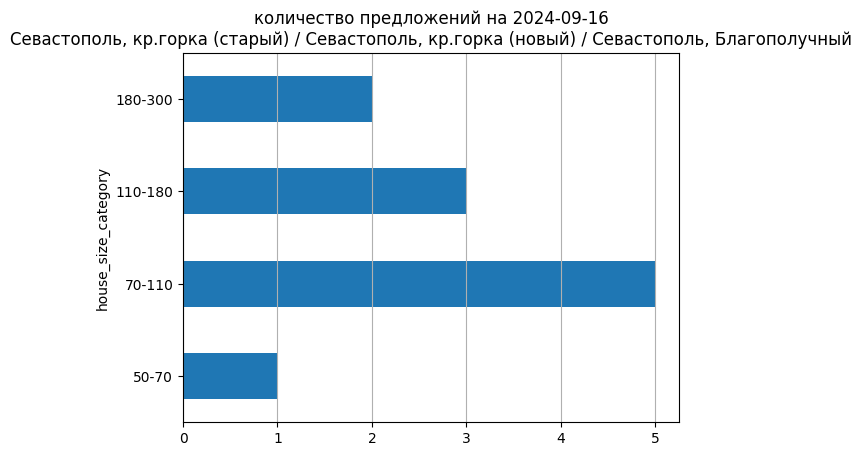

In [64]:
(
    gdf_last_local
    .drop_duplicates('url')
    .query('house_size_category in @sizes')
    .groupby(['house_size_category'], observed=True)['url'].count()
    .plot.barh(title='количество предложений на '+ str(dt_now) + '\n' + ' / '.join(area_name) )
    .grid(axis='x')    
)

In [65]:
sizes_ = ['70-110','110-180',] # '180-300' ]
# gdf_last_local.query('house_size_category in @sizes_')

array([[<Axes: ylabel='Density'>, <Axes: ylabel='Density'>],
       [<Axes: ylabel='Density'>, <Axes: ylabel='Density'>]], dtype=object)

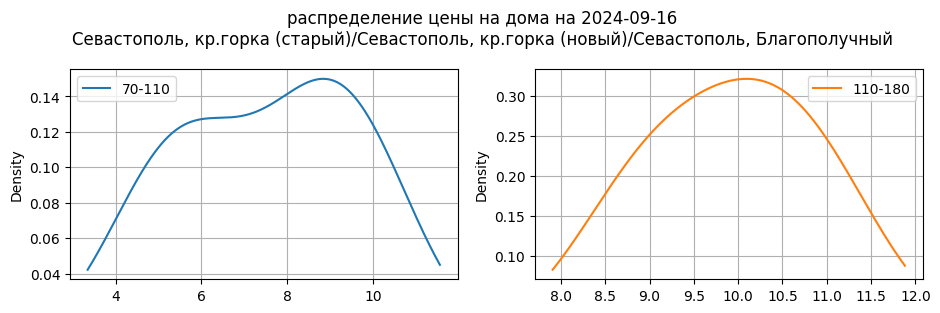

In [66]:
q_95 = gdf_last_local['priceM'].quantile(.95)

# fig, ax = plt.subplots() #figsize=(7,3) )
(
    gdf_last_local
    .query(f'(priceM<{q_95})')
    .query('house_size_category in @sizes_')
    #.groupby(['house_size_category'],observed=True)
    .pivot(columns='house_size_category',values='priceM')
    #['priceM']
    #.count()
    .plot.kde(
        legend=True,
        #ax=ax,
        # title='/'.join(area_name), 
        title=f'распределение цены на дома на '+ str( dt_now )+ '\n'+'/'.join(area_name), 
        grid=True,
        subplots=True,
        layout=(2,2),
        figsize=(11,6),
        sharex=False
    )   
)
#fig.suptitle(f'распределение цены на дома на '+ str( dt_now ), fontsize=16)
#fig.tight_layout()

----

In [67]:
# изменение цены по району
gdf_local = gdf.sjoin( frame_, how='inner', predicate='within') 

In [68]:
stat = (
        gdf_local
        # .groupby(['house_size_category','month'],observed=True)
        .groupby(['house_size_category','week'],observed=True)
        ['priceM'].describe(percentiles=percentiles)
        .dropna()
    )
display( stat )

count  mean  std   min    1%    5%  \
house_size_category week                                                        
30-50               2024-06-03/2024-06-09   3.00  5.90 0.09  5.85  5.85  5.85   
                    2024-06-10/2024-06-16   3.00  5.80 0.17  5.70  5.70  5.70   
                    2024-06-17/2024-06-23   3.00  5.80 0.17  5.70  5.70  5.70   
                    2024-06-24/2024-06-30   3.00  5.80 0.17  5.70  5.70  5.70   
                    2024-07-08/2024-07-14   3.00  5.82 0.16  5.70  5.70  5.71   
                    2024-07-15/2024-07-21   3.00  5.33 0.91  4.30  4.33  4.44   
                    2024-07-22/2024-07-28   2.00  5.00 0.99  4.30  4.31  4.37   
                    2024-07-29/2024-08-04   3.00  5.33 0.91  4.30  4.33  4.44   
                    2024-08-05/2024-08-11   2.00  4.30 0.00  4.30  4.30  4.30   
                    2024-08-19/2024-08-25   2.00  4.10 0.00  4.10  4.10  4.10   
50-70               2024-06-03/2024-06-09   3.00  7.27 0.79  6.35  6.38  6.49   
                    2024-06-10/2024-06-16   4.00  8.02 2.07  6.35  6.37  6.45   
                    2024-06-17/2024-06-23   5.00  7.03 0.69  6.35  6.35  6.35   
                    2024-06-24/2024-06-30   4.00  7.20 0.66  6.35  6.37  6.45   
                    2024-07-08/2024-07-14   3.00  7.48 0.42  7.00  7.01  7.07   
                    2024-07-29/2024-08-04   2.00  6.55 1.48  5.50  5.52  5.61   
70-110              2024-06-03/2024-06-09  13.00  7.60 2.57  5.22  5.23  5.24   
                    2024-06-10/2024-06-16  14.00  7.74 2.52  5.22  5.23  5.24   
                    2024-06-17/2024-06-23  15.00  7.66 2.45  5.22  5.23  5.24   
                    2024-06-24/2024-06-30  14.00  7.55 2.51  5.22  5.23  5.24   
                    2024-07-08/2024-07-14  10.00  7.95 2.45  5.22  5.22  5.22   
                    2024-07-15/2024-07-21  10.00  6.65 1.88  5.22  5.22  5.22   
                    2024-07-22/2024-07-28  12.00  7.15 1.83  5.22  5.23  5.24   
                    2024-07-29/2024-08-04  13.00  7.20 1.93  5.22  5.23  5.24   
                    2024-08-05/2024-08-11   8.00  6.65 1.79  5.20  5.20  5.22   
                    2024-08-12/2024-08-18  10.00  8.38 3.14  5.20  5.22  5.29   
                    2024-08-19/2024-08-25  13.00  8.88 2.87  5.40  5.40  5.40   
                    2024-08-26/2024-09-01   7.00  8.05 1.83  5.40  5.42  5.52   
                    2024-09-02/2024-09-08   9.00  7.53 1.97  5.40  5.40  5.40   
                    2024-09-09/2024-09-15   5.00  6.60 1.87  5.20  5.21  5.24   
                    2024-09-16/2024-09-22   5.00  7.56 2.06  5.40  5.40  5.40   
110-180             2024-06-03/2024-06-09   9.00 10.22 2.81  6.50  6.50  6.50   
                    2024-06-10/2024-06-16  15.00 10.58 2.66  6.50  6.50  6.50   
                    2024-06-17/2024-06-23  14.00  9.69 2.83  4.25  4.54  5.71   
                    2024-06-24/2024-06-30   9.00  8.92 2.92  4.25  4.43  5.15   
                    2024-07-08/2024-07-14  12.00  9.81 2.91  3.80  4.10  5.29   
                    2024-07-15/2024-07-21   7.00 10.07 3.64  3.75  4.06  5.29   
                    2024-07-22/2024-07-28   6.00  8.56 2.52  3.75  3.98  4.89   
                    2024-07-29/2024-08-04   8.00 10.42 1.94  8.30  8.34  8.51   
                    2024-08-05/2024-08-11   9.00 10.83 3.41  3.75  4.16  5.81   
                    2024-08-12/2024-08-18   7.00 10.56 3.75  3.75  4.06  5.29   
                    2024-08-19/2024-08-25   8.00  9.76 3.32  3.75  4.03  5.17   
                    2024-08-26/2024-09-01   5.00 10.21 2.55  7.80  7.84  8.02   
                    2024-09-02/2024-09-08   7.00 10.04 3.71  3.75  3.99  4.96   
                    2024-09-09/2024-09-15   6.00 10.20 4.03  3.75  3.95  4.76   
                    2024-09-16/2024-09-22   3.00  9.93 1.00  8.90  8.92  9.01   
180-300             2024-06-03/2024-06-09   2.00  8.25 2.47  6.50  6.54  6.67   
                    2024-06-10/2024-06-16   4.00 10.50 2.97  6.50  6.61  7

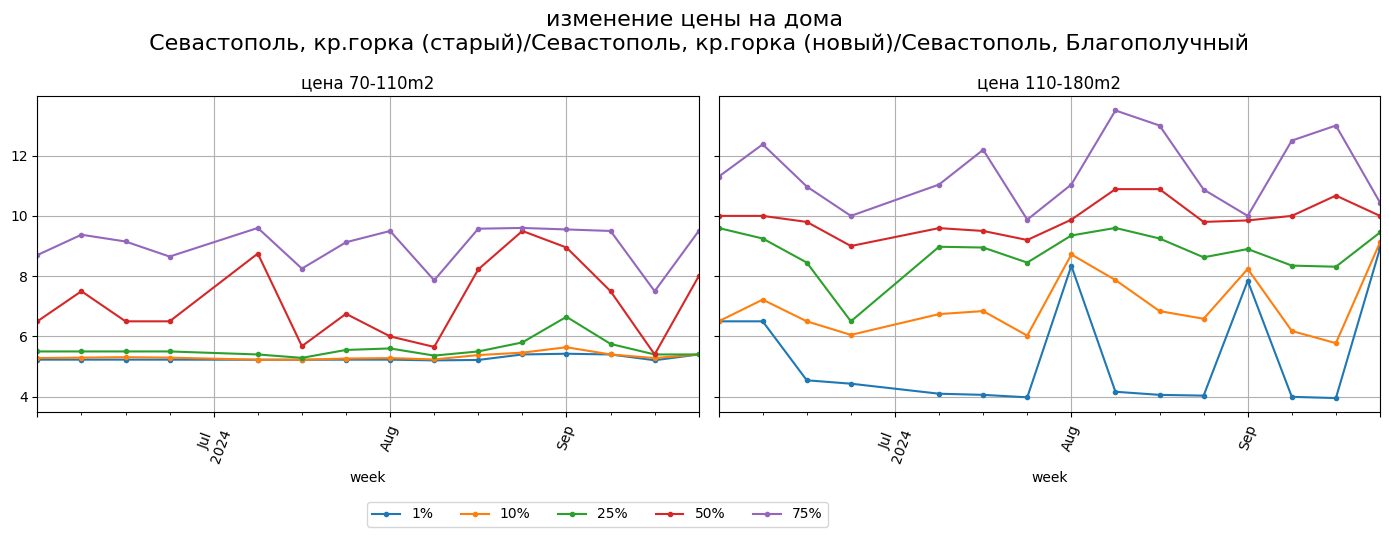

In [69]:
fig, ax = plt.subplots(1,len(sizes_),figsize=(14,5), sharey=True )

for i,s in enumerate(sizes_): 
    stat.loc[(s),cols].plot(title=f'цена {s}m2', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'изменение цены на дома\n {'/'.join(area_name)}', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

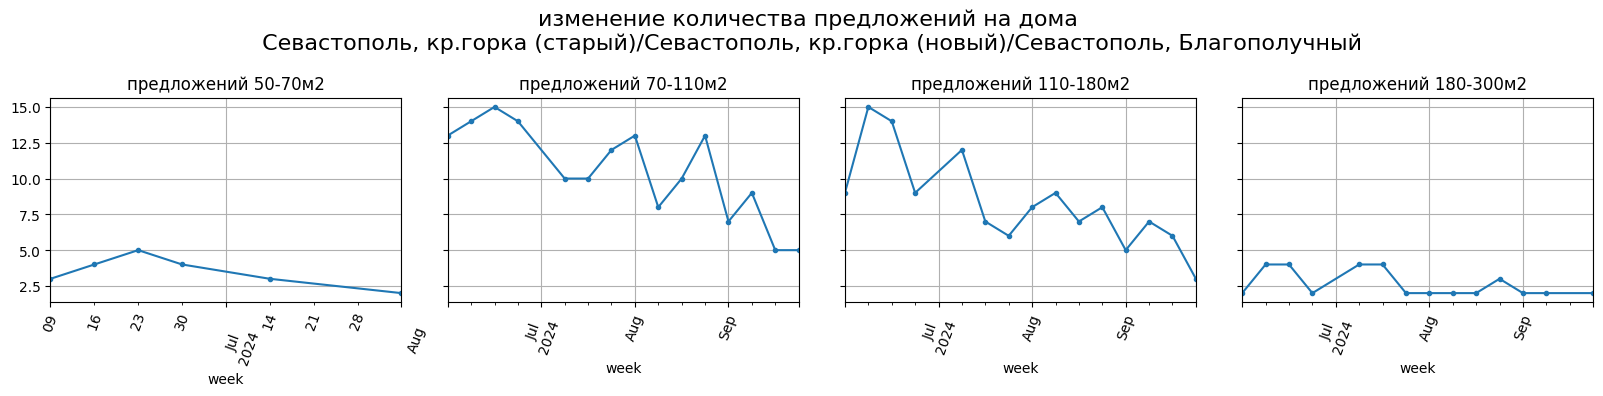

In [70]:
fig, ax = plt.subplots(1,len(sizes),figsize=(16,4), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(s),'count'].plot(title=f'предложений {s}м2', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'изменение количества предложений на дома\n {'/'.join(area_name)}', fontsize=16)

#fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()